In [2]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import imageio
from torchvision.utils import save_image

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
from data.FloorPlanLoader import *
from model.VQAE import VQAE
from utils import *
from train import *
import csv

#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy

In [3]:
#Hyperparameter
batch_size = 128
n_hiddens = 32
n_residual_hiddens = 32
n_residual_layers = 1
embedding_dim = 64
n_embeddings = 218
beta = .25
lr = 3e-3
noise=False
noise_weight=0.05
img_channel=1
vqae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
                n_embeddings, embedding_dim, 
                beta, img_channel).to(device)
vqae.load_state_dict(torch.load("../best_checkpoint/residential/200-vqae-0.12810542326018284.pt"))

<All keys matched successfully>

In [4]:
#Load Dataset
floor = FloorPlanDataset(root='../data/floorplan_crop/', subset = '../data/res_index.xlsx', preprocess=True)
data_loader = torch.utils.data.DataLoader(floor, batch_size=218, shuffle=False)

In [5]:
vqae.eval()
latents = None
with torch.no_grad():
    for data in data_loader:
        data = data.to(device)
        embedding_loss, quantized, perplexity, _ = vqae.latent(data)
        if latents is not None:
            latents = torch.cat([latents,quantized],dim=0)
        else: 
            latents = quantized

# Embedding Space Visualization

In [6]:
import numpy
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Visualize the latent

In [7]:
tsne = TSNE(n_components=2)
# apply t-SNE to data
data_2d = tsne.fit_transform(torch.flatten(latents, start_dim=1).cpu())

D:\Users\ALIENWARE\Anaconda3\envs\torch190\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\Users\ALIENWARE\Anaconda3\envs\torch190\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


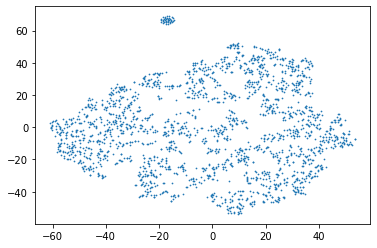

In [8]:
# Create a figure and a 3D axes object
fig = plt.figure()
ax = fig.add_subplot(111)

# Create the initial scatter plot
ax.scatter(data_2d[:, 0], data_2d[:, 1], s=0.5)

# Show the plot
plt.show()

### Clustering

In [9]:
#Import required module
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import pandas as pd
import seaborn as sns

In [10]:
data_2d[0]

array([-31.883549 ,   2.1101022], dtype=float32)

[1191 1239 2119 1492  170]


<string>:6: FutureWarning: Promotion of numbers and bools to strings is deprecated. In the future, code such as `np.concatenate((['string'], [0]))` will raise an error, while `np.asarray(['string', 0])` will return an array with `dtype=object`.  To avoid the warning while retaining a string result use `dtype='U'` (or 'S').  To get an array of Python objects use `dtype=object`. (Warning added in NumPy 1.21)


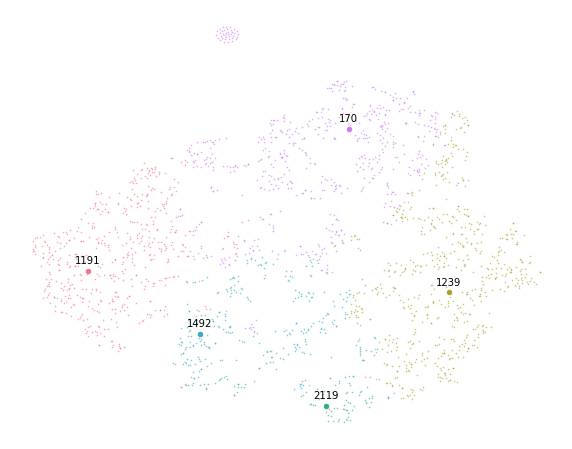

In [11]:
def cluster(latents, data_2d, n_clusters):
    #Initialize the class object
    kmeans = KMeans(n_clusters=n_clusters)
    
    data = torch.flatten(latents, start_dim=1).cpu()
    #predict the labels of clusters.
    label = kmeans.fit_predict(data)
    
    # get cluster centers
    cluster_centers = kmeans.cluster_centers_
    closest, _ = pairwise_distances_argmin_min(cluster_centers, data)
    
    # Save closest points and cluster centers to CSV
    df_center = pd.DataFrame({'Cluster Center': cluster_centers.tolist(), 'Closest Point Index': closest})
    df_center.to_csv(f'../results/clustercenter/{n_clusters}cluster_centers.csv', index=False)

    #Getting unique labels
    plt.figure(figsize=(10, 8))
    u_labels = np.unique(label)
    num_labels = len(u_labels)
    color_palette = sns.color_palette('husl', num_labels)

    #plotting the results:
    # plt.legend()
    
    center_list = closest
    print(center_list)
    
    for i, each in enumerate(center_list):
        plt.scatter(data_2d[each][0],data_2d[each][1], s=20, c=[color_palette[i]])
        plt.annotate(each, (data_2d[each][0],data_2d[each][1]), ha="center", va="center", xytext=(0,10), textcoords='offset points')
    for i in u_labels:
        plt.scatter(data_2d[label == i , 0] , data_2d[label == i , 1] , label = i, s=0.5, c=[color_palette[i]],alpha=0.5)
        
    plt.axis('off')
    plt.savefig('{n_clusters}_kmeans.png')
    df = np.stack((label, floor.all_data_dirs)).transpose()
    df = pd.DataFrame(df,columns=['label','data'])

    for i in u_labels:
        df.loc[df['label']==str(i)].to_csv(f'../results/{n_clusters}cluster{i}_{closest[i]}.csv',index=False)
        
    return kmeans, label
        
n_clusters=5
kmeans, label = cluster(latents, data_2d, n_clusters)

## Visualize the cluster center

In [17]:
cluster_count = n_clusters
file_path = f"../results/clustercenter/{cluster_count}cluster_centers.csv"
indexes = pd.read_csv(file_path)['Closest Point Index'].tolist()
indexes

[1191, 1239, 2119, 1492, 170]

In [18]:
def scale_crop(img): #B,C,H,W
    rescale = transforms.Compose([transforms.Resize(112),
                                  transforms.CenterCrop(56)])
    return rescale(img)

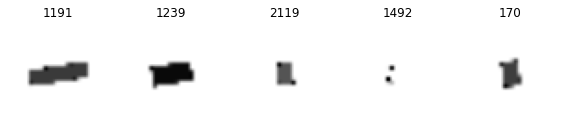

In [19]:
# Create a figure and axes with five subplots
fig, axes = plt.subplots(1, cluster_count, figsize=(8,3))
image_size = 112
crop_size = 56
# Iterate over the five subplots
for i, index in enumerate(indexes):
    image_path = f"../data/floorplan_crop/{index}.pt"
    # Read the image using matplotlib's imread
    image = torch.load(image_path)
    scaled = scale_crop(image)
    # Display the image in the corresponding subplot
    image_array = scaled.squeeze().numpy()
    axes[i].imshow(image_array, cmap='gray')
    axes[i].set_title(f"{index}")
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.savefig("../results/recon_img/{cluster_count}cluster_sample.png")

# Visualize and Save Reconstruction Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


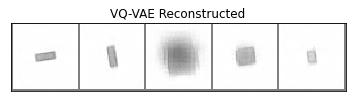

In [20]:
latent_centers = torch.from_numpy(kmeans.cluster_centers_.reshape(n_clusters, 64, 14, 14).astype('float32')).to(device)
vqae.eval()
valid_recon = vqae.decoder(latent_centers)
def show(img, title):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)
plt.figure()  # Create a new plot
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.savefig(f"{n_clusters}_VQrecon.png", bbox_inches='tight')

In [21]:
def rescale_img(img): #B,C,H,W
    rescale = transforms.Compose([transforms.Resize(112),
                                  transforms.Pad(56, fill=1.0)])
    return rescale(img)
rescaled_recon = rescale_img(valid_recon+0.5)

for i in range(rescaled_recon.shape[0]):
    save_image(rescaled_recon[i], f'../results/recon_img/{n_clusters}cluster-img{i}.jpg')
    
print('save to results/recon_img/*.jpg')

save to results/recon_img/*.jpg


## For rhino mapping-back 

In [22]:
import glob
import cv2
import os
import numpy as np
import torchvision.transforms.functional as TF
import imageio
import matplotlib.pyplot as plt

In [23]:
folder_path = "../results/recon_img/"  
img_files = []
for filename in os.listdir(folder_path):
    if "5cluster" in filename:
        print(filename)
        img_files.append(filename)

5cluster-img0.jpg
5cluster-img0_rectangle.jpg
5cluster-img1.jpg
5cluster-img1_rectangle.jpg
5cluster-img2.jpg
5cluster-img2_rectangle.jpg
5cluster-img3.jpg
5cluster-img3_rectangle.jpg
5cluster-img4.jpg
5cluster-img4_rectangle.jpg


In [24]:
def calc_height(image_path):
    print(image_path)
    fullpath = f"../results/recon_img/"+str(image_path)
    image = cv2.imread(fullpath)
    height, width, channels = image.shape
    print(height, width, channels)
    
    # Calculate the starting and ending indices for the central region
    start = (height - central_region_size) // 2
    end = start + central_region_size
    
    # Get the average pixel value in the central region for each channel
    central_region = image[start:end, start:end, :]
    average_pixel_value = np.mean(central_region, axis=(0,1))
    
    # Draw a red rectangle around the central region
    img_with_rectangle = np.copy(image)
    cv2.rectangle(img_with_rectangle, (start, start), (end, end), (0, 0, 255), 2)  # Draw red rectangle
    
    # Save the image with the red rectangle
    image_with_rectangle_path = fullpath.replace(".jpg", "_rectangle.jpg")  # Update the path as per your requirement
    imageio.imwrite(image_with_rectangle_path, img_with_rectangle)
    print(image_with_rectangle_path)
    return average_pixel_value

central_region_size = 10
height_info = []
for image_path in img_files:
    average_pixel_value = calc_height(image_path)
    height_info.append(average_pixel_value[0])

5cluster-img0.jpg
224 224 3
../results/recon_img/5cluster-img0_rectangle.jpg
5cluster-img0_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img0_rectangle_rectangle.jpg
5cluster-img1.jpg
224 224 3
../results/recon_img/5cluster-img1_rectangle.jpg
5cluster-img1_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img1_rectangle_rectangle.jpg
5cluster-img2.jpg
224 224 3
../results/recon_img/5cluster-img2_rectangle.jpg
5cluster-img2_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img2_rectangle_rectangle.jpg
5cluster-img3.jpg
224 224 3
../results/recon_img/5cluster-img3_rectangle.jpg
5cluster-img3_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img3_rectangle_rectangle.jpg
5cluster-img4.jpg
224 224 3
../results/recon_img/5cluster-img4_rectangle.jpg
5cluster-img4_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img4_rectangle_rectangle.jpg


In [25]:
height_info

[170.12, 206.37, 176.69, 209.12, 132.11, 187.8, 177.97, 206.41, 213.68, 217.87]

In [26]:
# Loop through each image
image_paths = glob.glob('recon_img/*.png')
lower_thres = 0.3
higher_thres = 0.7
for image_path in image_paths:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.convertScaleAbs(gray)
    edges = cv2.Canny(gray, lower_thres, higher_thres)  # Adjust the threshold values as needed

    # Save the edge image
    filename = os.path.splitext(os.path.basename(image_path))[0]  # Extract the filename without extension
    edge_image_path = f'edge_img/{filename}_edge.jpg'
    cv2.imwrite(edge_image_path, edges)